# Kiwi Challenge 2018

## Deep Learning

## Model 2: Build a Logistic regression model using tensorflow

In this Notebook, all the steps are explained for a better understanding of the program, some additional code that does not appear in this Notebook, it will be found in the Python code. Details of this challengue can be found [here](https://github.com/KiwiCampusChallenge/Kiwi-Campus-Challenge/blob/master/Deep-Learning-Challenge.md), please before starting, you have to run the command **python app.py download** explained earlier in ** app.ipynb**

## Step 0: Read training Set or test Set from directory

In [2]:
import cv2
import time,random
import os,shutil
import urllib.request
import zipfile
import click
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from PIL import Image
from tensorflow.contrib.layers import flatten
NUM_CLASSES=43

def read_train_test_from_directory(path_dir):
    print("Reading data from: ",path_dir)
    Xtrain_test=[]
    Ytrain_test=[]
    for i in range(NUM_CLASSES):
        pathfile=path_dir+str(i)+"/"
        for file in os.listdir(pathfile):
            if os.path.isfile(os.path.join(pathfile, file)):
                Xtrain_test.append(np.array(Image.open(os.path.join(pathfile, file))))
                Ytrain_test.append(i)
    return np.array(Xtrain_test),np.array(Ytrain_test)

If we want to read the training data, we will call with the following command.

In [3]:
Xtrain,Ytrain=read_train_test_from_directory("images/train/")
print("Number of images: ",Xtrain.shape[0])
print("Dimensions of any images: ",Xtrain[12].shape)
print("Label class: ",Ytrain[12])

Reading data from:  images/train/
Number of images:  976
Dimensions of any images:  (25, 25, 3)
Label class:  1


in the same way that, with testSet

In [5]:
Xtest,Ytest=read_train_test_from_directory("images/test/")
print("Number of images: ",Xtest.shape[0])
print("Dimensions of any images: ",Xtest[15].shape)
print("Label class: ",Ytest[15])

Reading data from:  images/test/
Number of images:  237
Dimensions of any images:  (26, 26, 3)
Label class:  1


# Step 1: Transform Images and normalize

## Data Augmentation
The data presented is small, so it is advisable to increase the data artificially through some transformations.
We increase four times the data.

In [6]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .10 + np.random.uniform()/3.0
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1


def transform_image(img):
    ang_range = 5
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = augment_brightness_camera_images(img)
    return img


def data_augmentation(X, Y):
    x1=[]
    y1=[]
    for i in range(X.shape[0]):
        x1.append(X[i])
        y1.append(Y[i])
        for num in range(3):
            x1.append(transform_image(X[i]))
            y1.append(Y[i])
    return np.array(x1), np.array(y1)

For example if we have this image

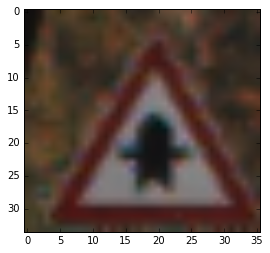

In [10]:
plt.imshow(Xtrain[454])
plt.show()

Some transformations of the previous image

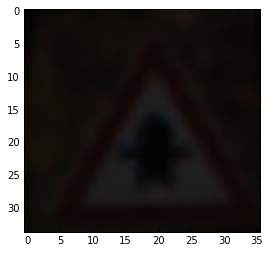

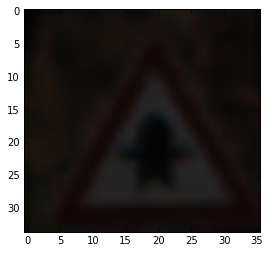

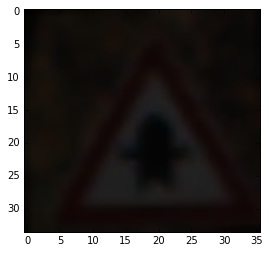

In [11]:
for i in range(3):
    plt.imshow(transform_image(Xtrain[454]))
    plt.show()

We can improve and make differents transformation,  (with this library) https://github.com/aleju/imgaug

# Feature Extraction
## Rescaling images and converts to grayscale
We resize the image to (32,32,3)
Every pixel in the image has values between [0,255], we normalize the data and transform to [-1,1]

In [12]:
def preprocess_data(X,Y):
    X_preprocess=[]
    num_of_images=X.shape[0]

    for i in range(num_of_images):
        X_preprocess.append(np.array(Image.fromarray(X[i]).resize((32, 32))))
    X_preprocess = np.array(X_preprocess)
    X_preprocess = X_preprocess.astype('float64')
    X_preprocess = (X_preprocess - 128.) / 128.

    images_gray = np.average(X_preprocess, axis=3)
    images_gray = np.expand_dims(images_gray, axis=3)
    y_onehot = np.zeros([Y.shape[0], NUM_CLASSES])

    for i in range(Y.shape[0]):
        y_onehot[i][int(Y[i])] = 1
    Y = y_onehot
    return images_gray,Y

# Step 2: Logistic Regression Model - Tensorflow
Models will be saved in models/model2/saved/checkpoint

In [41]:
def logistic_regression_tensorflow(dir_train_or_test,istraining,model=-1,Xinfer=None):
    # hyperparameters
    learning_rate = 0.01
    num_epochs = 40000
    display_step = 1000

    with tf.name_scope("Declaring_placeholder"):
        X = tf.placeholder(tf.float32, [None, 32*32])
        y = tf.placeholder(tf.float32, [None, 43])

    with tf.name_scope("Declaring_variables"):
        W = tf.Variable(tf.zeros([32*32, 43]))
        b = tf.Variable(tf.zeros([43]))

    with tf.name_scope("Declaring_functions"):
        y_ = tf.nn.softmax(tf.add(tf.matmul(X, W), b))

    with tf.name_scope("calculating_cost"):
        cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_), reduction_indices=1))

    with tf.name_scope("declaring_gradient_descent"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    saver = tf.train.Saver()

    if not os.path.exists("models"):
        os.makedirs("models")
    if not os.path.exists("models/model2"):
        os.makedirs("models/model2")
    if not os.path.exists("models/model2/saved"):
        os.makedirs("models/model2/saved")

    if istraining==True:
        Xtrain, Ytrain = read_train_test_from_directory(dir_train_or_test)
        #Xtrain, Ytrain = data_augmentation(Xtrain,Ytrain)
        Xtrain, Ytrain = preprocess_data(Xtrain, Ytrain)
        Xtrain = Xtrain.reshape([Xtrain.shape[0], -1])
        print("Training Logistic Regression Tensorflow ...")
        with tf.name_scope("starting_tensorflow_session"):
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for epoch in range(num_epochs):
                    cost_in_each_epoch = 0
                    _, c = sess.run([optimizer, cost], feed_dict={X: Xtrain, y: Ytrain})
                    cost_in_each_epoch += c
                    if (epoch+1) % display_step == 0:
                        print("Epoch {} of {} cost {:.5f} ".format(epoch + 1,num_epochs,c))
                    pathglobal=os.getcwd()+"/models/model2/saved/modeltf.ckpt"
                    if (epoch + 1) % 1000 == 0:
                        saver.save(sess,pathglobal,global_step=epoch+1)
                saver.save(sess, pathglobal, global_step=num_epochs)
                print("Saved Model")
    else:
        if model==-1:
            Xtest, Ytest = read_train_test_from_directory(dir_train_or_test)
            Xtest, Ytest = preprocess_data(Xtest, Ytest)
            Xtest = Xtest.reshape([Xtest.shape[0], -1])
            with tf.Session() as sess:
                pathglobal = os.getcwd() + "/models/model2/saved/"
                saver.restore(sess, tf.train.latest_checkpoint(pathglobal))
                accuracy = sess.run(accuracy_operation, feed_dict={X: Xtest, y: Ytest})
                print("Test Accuracy = {:.3f}".format(accuracy))
        else:
            with tf.Session() as sess:
                pathglobal = os.getcwd() + "/models/model2/saved/"
                saver.restore(sess, tf.train.latest_checkpoint(pathglobal))
                _=np.zeros([Xinfer.shape[0],NUM_CLASSES])
                predictions = sess.run(y_, feed_dict={X: Xinfer, y: _})
                predictions=np.array(predictions)
                return np.argmax(predictions,1)
    return ;

I have commented #Xtrain, Ytrain = data_augmentation(Xtrain,Ytrain) but you can uncommented

## Training
To train the model use this command - **python app.py train -m model2 -d images/train**

In [35]:
def train(m, d):
    print("Training Phase")
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if m=="model1":
        print("Task3: Logistic Regresion - Scikit")
        logistic_regression_scikit(d,True)

    if m=="model2":
        print("Task4: Logistic Regresion - Tensorflow")
        logistic_regression_tensorflow(d,True)

    if m=="model3":
        print("Task5: LeNet Architecture - Tensorflow")
        lenet_tensorflow(d,True)

In [42]:
tf.reset_default_graph()
train("model2","images/train")

Training Phase
Task4: Logistic Regresion - Tensorflow
Reading data from:  images/train/
Training Logistic Regression Tensorflow ...
Epoch 1000 of 40000 cost 1.20540 
Epoch 2000 of 40000 cost 0.82249 
Epoch 3000 of 40000 cost 0.63841 
Epoch 4000 of 40000 cost 0.52818 
Epoch 5000 of 40000 cost 0.45381 
Epoch 6000 of 40000 cost 0.39961 
Epoch 7000 of 40000 cost 0.35799 
Epoch 8000 of 40000 cost 0.32482 
Epoch 9000 of 40000 cost 0.29762 
Epoch 10000 of 40000 cost 0.27485 
Epoch 11000 of 40000 cost 0.25548 
Epoch 12000 of 40000 cost 0.23877 
Epoch 13000 of 40000 cost 0.22420 
Epoch 14000 of 40000 cost 0.21138 
Epoch 15000 of 40000 cost 0.20000 
Epoch 16000 of 40000 cost 0.18982 
Epoch 17000 of 40000 cost 0.18066 
Epoch 18000 of 40000 cost 0.17237 
Epoch 19000 of 40000 cost 0.16483 
Epoch 20000 of 40000 cost 0.15794 
Epoch 21000 of 40000 cost 0.15161 
Epoch 22000 of 40000 cost 0.14578 
Epoch 23000 of 40000 cost 0.14039 
Epoch 24000 of 40000 cost 0.13539 
Epoch 25000 of 40000 cost 0.13073 
Ep

# Testing our model
To train the model use this command - **python app.py test -m model2 -d images/test**

In [37]:
def test(m, d):
    print("Test Phase")
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if m=="model1":
        if not os.path.isfile("models/model1/saved/model1.sav"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model1 -d images/test)")
            return
        print("Task3: Logistic Regresion - Scikit")
        logistic_regression_scikit(d,False)

    if m=="model2":
        if not os.path.isfile("models/model2/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model2 -d images/test)")
            return
        print("Task4: Logistic Regresion - Tensorflow")
        logistic_regression_tensorflow(d,False)

    if m=="model3":
        if not os.path.isfile("models/model3/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model3 -d images/test)")
            return
        print("Task5: LeNet Architecture - Tensorflow")
        lenet_tensorflow(d,False)

In [43]:
tf.reset_default_graph()
test("model2","images/test")

Test Phase
Task4: Logistic Regresion - Tensorflow
Reading data from:  images/test/
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model2/saved/modeltf.ckpt-40000
Test Accuracy = 0.949


In [45]:
tf.reset_default_graph() 
test("model2","images/train")

Test Phase
Task4: Logistic Regresion - Tensorflow
Reading data from:  images/train/
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model2/saved/modeltf.ckpt-40000
Test Accuracy = 0.999


Our model predicts with accuracy 94.9%

The descriptions of classes is obtained with the following function.

In [46]:
def get_label(pathreadme="data/FullIJCNN2013/ReadMe.txt"):
    label=[]
    startline=0
    with open(pathreadme, mode='rb') as f:
        for line in f:
            x=str(line.strip())
            strline = str(startline) + " ="
            if strline in x:
                label.append(x[6:(len(x)-1)].strip())
                startline = startline + 1
    f.close()
    return np.array(label)
label=get_label()

**Some positives predictions in our model:**

Reading data from:  images/test/
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model2/saved/modeltf.ckpt-40000


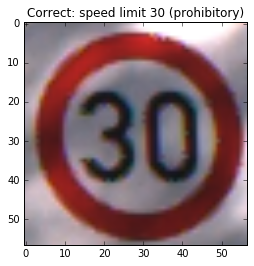

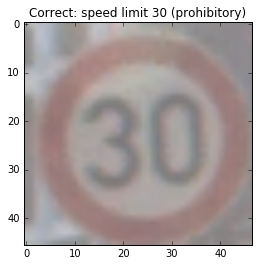

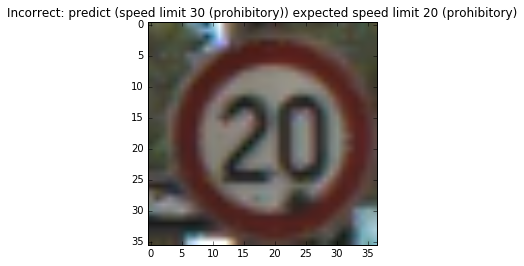

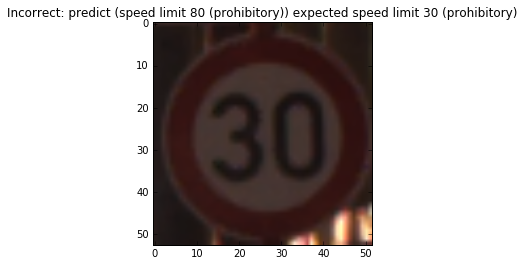

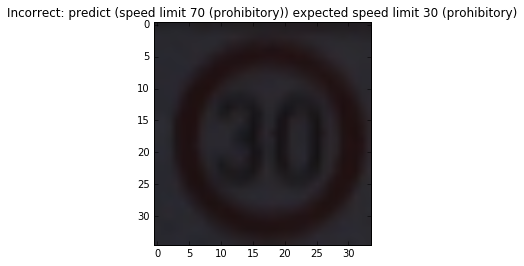

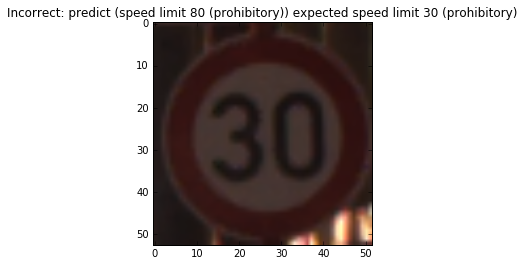

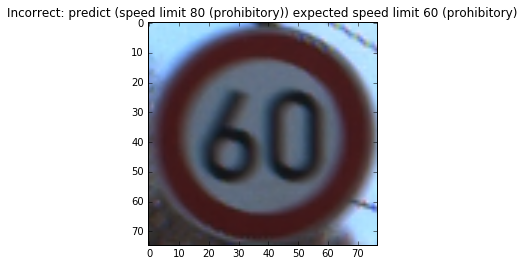

In [56]:
tf.reset_default_graph() 
with tf.name_scope("Declaring_placeholder"):
    X = tf.placeholder(tf.float32, [None, 32*32])
    y = tf.placeholder(tf.float32, [None, 43])

with tf.name_scope("Declaring_variables"):
    W = tf.Variable(tf.zeros([32*32, 43]))
    b = tf.Variable(tf.zeros([43]))

with tf.name_scope("Declaring_functions"):
    y_ = tf.nn.softmax(tf.add(tf.matmul(X, W), b))

with tf.name_scope("calculating_cost"):
    cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_), reduction_indices=1))

with tf.name_scope("declaring_gradient_descent"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
Xtest, Ytest = read_train_test_from_directory("images/test/")
bk_Xtest = Xtest
bk_Ytest = Ytest
Xtest, Ytest = preprocess_data(Xtest, Ytest)
Xtest = Xtest.reshape([Xtest.shape[0], -1])

with tf.Session() as sess:
	pathglobal = os.getcwd() + "/models/model2/saved/"
	saver.restore(sess, tf.train.latest_checkpoint(pathglobal))
	predicts = sess.run(y_, feed_dict={X: Xtest, y: Ytest})
	predicts = np.argmax(predicts,1) 
	cont=0
	for i in range(len(predicts)):
		if bk_Ytest[i]==predicts[i]:
			plt.imshow(bk_Xtest[i])
			plt.title("Correct: "+label[bk_Ytest[i]])
			plt.show()
			cont=cont+1 
			if cont==2:
				break
	cont=0
	for i in range(len(predicts)):
		if bk_Ytest[i]!=predicts[i]:
			plt.imshow(bk_Xtest[i])
			plt.title("Incorrect: predict ("+label[predicts[i]]+") expected "+label[bk_Ytest[i]])
			plt.show()
			cont=cont+1 
			if cont==5:
				break


# Inferences our model
To infer the model use this command - **python app.py infer -m model2 -d images/user**

In [57]:
def infer(m, d):
    print("Inference Phase - Path ",d)
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if not os.path.exists("images"):
        os.makedirs("images")
    if not os.path.exists("images/user"):
        os.makedirs("images/user")

    #get label of every class  (extracted from data/ReadMe.txt)
    label = get_label()
    label = np.array(label)
    Xinfer = []
    path_dir=d

    for file in os.listdir(path_dir):
        if os.path.isfile(os.path.join(path_dir, file)):
            if not file.endswith(".txt") and not file.endswith(".zip") \
                    and not file.endswith(".gzip") and not file.endswith(".md"):
                Xinfer.append(np.array(Image.open(os.path.join(path_dir, file))))
    Xinfer = np.array(Xinfer)
    _ = np.zeros(1)

    Xinfer, _ = preprocess_data(Xinfer, _)
    predictions = []

    if m == "model1":
        if not os.path.isfile("models/model1/saved/model1.sav"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model1 -d images/test)")
            return
        Xinfer = Xinfer.reshape([Xinfer.shape[0], -1])
        print("Task6: Inference in Logistic Regresion - Scikit")
        predictions = logistic_regression_scikit(d,False, 1, Xinfer)
        print(predictions)

    if m == "model2":
        if not os.path.isfile("models/model2/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model2 -d images/test)")
            return

        print("Task6: Inference in Logistic Regresion - Tensorflow")
        Xinfer = Xinfer.reshape([Xinfer.shape[0], -1])
        predictions = logistic_regression_tensorflow(d,False, 2, Xinfer)
        print(predictions)

    if m == "model3":
        if not os.path.isfile("models/model3/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model3 -d images/test)")
            return
        print("Task6: Inference in LeNet Architecture - Tensorflow")
        predictions = lenet_tensorflow(d,False, 3, Xinfer)
        print(predictions)

    predictions = np.array(predictions)
    cont = 0

    for file in os.listdir(path_dir):
        if os.path.isfile(os.path.join(path_dir, file)):
            if not file.endswith(".txt") and not file.endswith(".zip") \
                    and not file.endswith(".gzip") and not file.endswith(".md"):
                filepath = path_dir + file
                txt = str("Class ")
                txt = txt + str(predictions[cont])
                txt = txt + str(": ")
                txt = txt + label[predictions[cont]]
                print("label: ", txt)
                x = plt.imread(filepath)
                plt.imshow(x)
                plt.title(txt)
                plt.show()
                cont = cont + 1

Inference Phase - Path  images/user
Task6: Inference in Logistic Regresion - Tensorflow
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model2/saved/modeltf.ckpt-40000
[16 38 14 13]
label:  Class 16: no trucks (prohibitory)


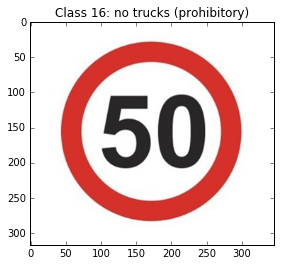

label:  Class 38: keep right (mandatory)


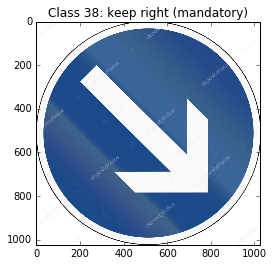

label:  Class 14: stop (other)


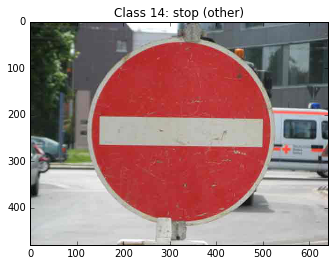

label:  Class 13: give way (other)


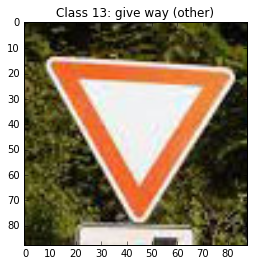

In [60]:
tf.reset_default_graph()
infer("model2","images/user")